In [1]:
import pandas as pd

In [2]:
data1 = pd.read_csv('data/2017firsthalf.txt', sep="\t", encoding='latin-1', dtype={'componentText': str})
data2 = pd.read_csv('data/2017secondhalf.txt', sep="\t", encoding='latin-1', dtype={'componentText': str})
data3 = pd.read_csv('data/2018.txt', sep="\t", encoding='latin-1', dtype={'componentText': str})

In [3]:
transcript_train = pd.concat([data1, data2, data3])
#transcript_train = data1

In [4]:
transcript_train.describe()

,objectId
count,5.591340e+05
mean,3.263534e+06
std,1.537792e+07
min,1.871100e+04
25%,3.647800e+04
50%,1.776980e+05
75%,3.053040e+05
max,1.418857e+08


In [5]:
transcript_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559134 entries, 0 to 290801
Data columns (total 3 columns):
objectId                     559134 non-null int64
transcriptcreationdateUTC    559134 non-null object
componentText                559134 non-null object
dtypes: int64(1), object(2)
memory usage: 17.1+ MB


In [6]:
transcript_train.head()

,objectId,transcriptcreationdateUTC,componentText
0,106335,2017-01-04 15:40:41.000,Good morning. My name is Kalia and I will be y...
1,106335,2017-01-04 15:40:41.000,"Thank you, Kalia, and welcome, everyone, to Fo..."
2,106335,2017-01-04 15:40:41.000,"Thank you, Erich, and Happy New Year to everyo..."
3,106335,2017-01-04 15:40:41.000,"Great. Thanks, Mark. And welcome, everyone, to..."
4,106335,2017-01-04 15:40:41.000,"Thank you, Emily. And I'm just going to take a..."


In [7]:
transcript_train['transcriptcreationdateUTC'] = pd.to_datetime(transcript_train['transcriptcreationdateUTC'])

In [8]:
transcript_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559134 entries, 0 to 290801
Data columns (total 3 columns):
objectId                     559134 non-null int64
transcriptcreationdateUTC    559134 non-null datetime64[ns]
componentText                559134 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.1+ MB


In [9]:
import spacy
from spacy import displacy

In [10]:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.1.0/en_core_web_sm-2.1.0.tar.gz

In [11]:
import en_core_web_sm

In [12]:
nlp = en_core_web_sm.load()

In [13]:
#transcript_train['componentText'] = transcript_train['componentText'].to_string()

In [14]:
%%time
transcript_train['parsed_componentText'] = transcript_train.iloc[:,2].apply(lambda x: nlp(x))
#test = nlp(transcript_train.iloc[:,2])

CPU times: user 12h 30min 33s, sys: 3min 36s, total: 12h 34min 9s
Wall time: 2h 32min 55s


In [15]:
transcript_train.iloc[:,3][0]

0    (Good, morning, ., My, name, is, Kalia, and, I...
0    (Good, day, ,, ladies, and, gentlemen, ., Than...
0    (Ladies, and, gentlemen, ,, thank, you, for, s...
Name: parsed_componentText, dtype: object

In [16]:
# lemmatization and removing stop words
transcript_train['parsed_componentText_lemma'] = transcript_train.iloc[:,3].apply(lambda text: 
                                          " ".join(token.lemma_ for token in text if not token.is_stop))

In [17]:
transcript_train.iloc[:,4][0]

0    good morning . Kalia conference operator today...
0    good day , lady gentleman . thank stand . welc...
0    lady gentleman , thank stand , welcome Ford Mo...
Name: parsed_componentText_lemma, dtype: object

In [18]:
# Adding customized stop words
# # New stop words list 
# customize_stop_words = [
#     'attach'
# ]

# # Mark them as stop words
# for w in customize_stop_words:
#     nlp.vocab[w].is_stop = True

In [19]:
transcript_train['month'] = transcript_train['transcriptcreationdateUTC'].apply(lambda x: x.month)

In [20]:
transcript_train1=transcript_train.groupby(['objectId','month'])['parsed_componentText_lemma'].apply(' '.join).reset_index()

In [21]:
transcript_train1

,objectId,month,parsed_componentText_lemma
0,18711,2,"good day , lady gentleman , welcome Allstate F..."
1,18711,3,"good afternoon . , slot presentation Raymond J..."
2,18711,5,"good day , lady gentleman , welcome Allstate Q..."
3,18711,7,"okay . good morning , . Greg Peters . insuranc..."
4,18711,8,"good day , lady gentleman , welcome Allstate S..."
...,...,...,...
940,141885706,8,"good morning , thank stand . welcome AbbVie Se..."
941,141885706,9,"thank , everybody join session AbbVie . need r..."
942,141885706,10,"good morning , thank hold . welcome AbbVie Qua..."
943,141885706,11,"good morning , thank hold . welcome AbbVie Qua..."


In [22]:
# test = list(transcript_train1.iloc[:1,2].apply(lambda x: x.noun_chunks))
# Modeling bigrams and trigrams

In [23]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [24]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [25]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

#data_words = list(sent_to_words(data))

In [27]:
transcript_train1['list_of_words'] = list(sent_to_words(transcript_train1['parsed_componentText_lemma']))

In [28]:
transcript_train1.head()

,objectId,month,parsed_componentText_lemma,list_of_words
0,18711,2,"good day , lady gentleman , welcome Allstate F...","[good, day, lady, gentleman, welcome, allstate..."
1,18711,3,"good afternoon . , slot presentation Raymond J...","[good, afternoon, slot, presentation, raymond,..."
2,18711,5,"good day , lady gentleman , welcome Allstate Q...","[good, day, lady, gentleman, welcome, allstate..."
3,18711,7,"okay . good morning , . Greg Peters . insuranc...","[okay, good, morning, greg, peters, insurance,..."
4,18711,8,"good day , lady gentleman , welcome Allstate S...","[good, day, lady, gentleman, welcome, allstate..."


In [29]:
# Build the bigram and trigram models
transcript_train1['bigram'] = gensim.models.Phrases(transcript_train1['list_of_words'], min_count=5, threshold=10) # higher threshold fewer phrases.

# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [30]:
%%time
# # Faster way to get a sentence clubbed as a trigram/bigram
transcript_train1['bigram_mod'] = transcript_train1['bigram'].apply(lambda x: gensim.models.phrases.Phraser(x))
# trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 4h 25min, sys: 9.27 s, total: 4h 25min 9s
Wall time: 4h 25min 10s


In [31]:
transcript_train1['bigram_text'] = transcript_train1['bigram_mod'].apply(lambda x: x[transcript_train1['list_of_words']])

In [32]:
# Create Dictionary
# transcript_train1['id2word'] = transcript_train1['bigram_text'].apply(lambda x: corpora.Dictionary(x))


In [33]:
%%time
id2word = corpora.Dictionary(transcript_train1['bigram_text'][0])

CPU times: user 59.8 s, sys: 48.5 ms, total: 59.9 s
Wall time: 59.9 s


In [34]:
corpus = [id2word.doc2bow(x) for x in transcript_train1['bigram_text'][0]]

In [35]:
texts = []
for i in range(len(transcript_train1['bigram_text'][0])):
    texts.append(transcript_train1['bigram_text'][0][i])
    
    

In [36]:
%%time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=25,
                                           alpha='auto',
                                           per_word_topics=True)

CPU times: user 12min 47s, sys: 1.93 s, total: 12min 49s
Wall time: 1min 36s


In [37]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"client" + 0.013*"market" + 0.013*"think" + 0.010*"business" + '
  '0.009*"service" + 0.008*"technology" + 0.008*"value" + 0.008*"year" + '
  '0.008*"growth" + 0.007*"cost"'),
 (1,
  '0.016*"project" + 0.012*"million" + 0.011*"year" + 0.010*"asset" + '
  '0.010*"billion" + 0.009*"capital" + 0.008*"look" + 0.008*"think" + '
  '0.008*"go" + 0.007*"return"'),
 (2,
  '0.026*"patient" + 0.016*"product" + 0.010*"year" + 0.008*"like" + '
  '0.007*"new" + 0.006*"physician" + 0.006*"diabetes" + 0.006*"launch" + '
  '0.006*"value" + 0.006*"question"'),
 (3,
  '0.023*"patient" + 0.020*"think" + 0.014*"datum" + 0.011*"look" + '
  '0.011*"study" + 0.009*"question" + 0.007*"line" + 0.007*"trial" + '
  '0.006*"year" + 0.006*"opportunity"'),
 (4,
  '0.022*"company" + 0.016*"shareholder" + 0.016*"thank" + 0.011*"question" + '
  '0.010*"proposal" + 0.010*"meeting" + 0.010*"year" + 0.009*"board" + '
  '0.008*"vote" + 0.008*"business"'),
 (5,
  '0.048*"think" + 0.029*"go" + 0.019*"thing" + 0

In [38]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.308699251614518

Coherence Score:  0.36432400239424745


In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.049074 -0.029237       1        1  15.549821
19    -0.174079  0.020722       2        1  11.928339
7      0.034314  0.061881       3        1   7.407468
12    -0.159025  0.012219       4        1   6.177186
10    -0.056892  0.032748       5        1   5.968989
3      0.017526 -0.159884       6        1   5.959477
14     0.161467  0.039452       7        1   5.122925
13     0.015961  0.046119       8        1   4.862730
15     0.021096  0.012382       9        1   4.843055
16     0.121317  0.036030      10        1   4.406715
1     -0.077333 -0.005122      11        1   4.406432
4      0.004827 -0.098465      12        1   3.857120
6     -0.061827 -0.087914      13        1   3.326952
8      0.065085  0.057446      14        1   3.154014
0      0.072403 -0.005530      15        1   2.840907
18    -0.164126  0.086493      16        1   2.396631
17     0.099130  0.070765      17        1   2.371936
11    -0.016112  0.046356      18        1   1.926897
9      0.024582  0.054404      19        1   1.781861
2      0.022612 -0.190866      20        1   1.710543, topic_info=     Category           Freq      Term          Total  loglift  logprob
1416  Default  238657.000000   quarter  238657.000000  30.0000  30.0000
420   Default  147374.000000  customer  147374.000000  29.0000  29.0000
3819  Default   68352.000000   patient   68352.000000  28.0000  28.0000
789   Default  258523.000000    growth  258523.000000  27.0000  27.0000
2578  Default   38634.000000     store   38634.000000  26.0000  26.0000
...       ...            ...       ...            ...      ...      ...
1792  Topic20    2978.972656     think  511397.125000  -1.0772  -5.2365
313   Topic20    2600.403320   company  133675.187500   0.1286  -5.3724
166   Topic20    2415.593750      base   78402.226562   0.5885  -5.4461
1043  Topic20    2364.183105       low   70809.101562   0.6688  -5.4676
1784  Topic20    2353.660645      term  157357.796875  -0.1342  -5.4721

[1752 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
23960     13  0.998232     abbott
21968      6  0.000785     abbvie
21968     13  0.998872     abbvie
10599      7  0.983729  accenture
10599     10  0.016093  accenture
...      ...       ...        ...
18916      8  0.985020     yogurt
8999       7  0.057072    youtube
8999      10  0.754824    youtube
8999      14  0.180421    youtube
8999      19  0.007364    youtube

[7438 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 20, 8, 13, 11, 4, 15, 14, 16, 17, 2, 5, 7, 9, 1, 19, 18, 12, 10, 3])

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

In [40]:
# How to find the optimal number of topics for LDA?
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [41]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=2)

CPU times: user 1h 44min 7s, sys: 1min 2s, total: 1h 45min 9s
Wall time: 1h 26min 34s


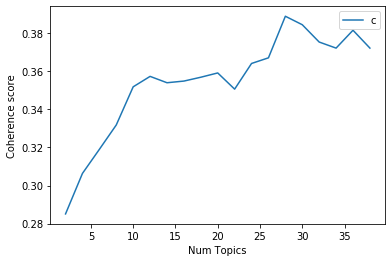

In [42]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2851
Num Topics = 4  has Coherence Value of 0.3064
Num Topics = 6  has Coherence Value of 0.319
Num Topics = 8  has Coherence Value of 0.3318
Num Topics = 10  has Coherence Value of 0.3519
Num Topics = 12  has Coherence Value of 0.3573
Num Topics = 14  has Coherence Value of 0.354
Num Topics = 16  has Coherence Value of 0.3549
Num Topics = 18  has Coherence Value of 0.3569
Num Topics = 20  has Coherence Value of 0.3592
Num Topics = 22  has Coherence Value of 0.3506
Num Topics = 24  has Coherence Value of 0.3641
Num Topics = 26  has Coherence Value of 0.3671
Num Topics = 28  has Coherence Value of 0.3889
Num Topics = 30  has Coherence Value of 0.3845
Num Topics = 32  has Coherence Value of 0.3754
Num Topics = 34  has Coherence Value of 0.3722
Num Topics = 36  has Coherence Value of 0.3816
Num Topics = 38  has Coherence Value of 0.3722


Emotion and Sentiment Analysis

In [44]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [45]:
transcript_train1['vader'] = transcript_train1.iloc[:,2].apply(lambda x: sid.polarity_scores(x))

In [46]:
transcript_train1['vader'][2]

{'neg': 0.051, 'neu': 0.694, 'pos': 0.255, 'compound': 1.0}

In [47]:
neg_score = list(transcript_train1['vader'].apply(lambda x: x['neg']))

(array([ 70., 352., 352., 111.,  34.,  13.,   7.,   5.,   0.,   1.]),
 array([0.008 , 0.0205, 0.033 , 0.0455, 0.058 , 0.0705, 0.083 , 0.0955,
        0.108 , 0.1205, 0.133 ]),
 <a list of 10 Patch objects>)

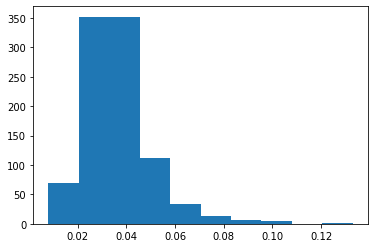

In [48]:
plt.hist(neg_score)

(array([  8.,   0.,   2.,  34., 123., 322., 323., 110.,  21.,   2.]),
 array([0.105 , 0.1306, 0.1562, 0.1818, 0.2074, 0.233 , 0.2586, 0.2842,
        0.3098, 0.3354, 0.361 ]),
 <a list of 10 Patch objects>)

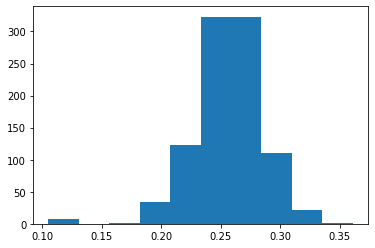

In [49]:
pos_score = list(transcript_train1['vader'].apply(lambda x: x['pos']))
plt.hist(pos_score)

In [ ]:
#random cut forest to filter out outlier
# PCA
# classification/regression

#visualization
# word cloud, feature importance, S&P global leaflet, 